## NYC taxi trip duration prediction using Linear Regression 


### Loading Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

## Reading Dataset

In [2]:
import os
os.chdir(r"D:\Datascience\Analytics vidya\LabAV\NYC Taxi Trip Duration Prediction ML")

In [3]:
data= pd.read_csv("nyc_taxi_trip_duration.csv", parse_dates=["pickup_datetime","dropoff_datetime"])

In [4]:
data.shape

(729322, 11)

In [5]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


In [6]:
data.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

#### No Missing value treatment needed

## Statistical summary 

In [7]:
data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,729322.000000,729322.000000,729322.000000,729322.000000,729322.000000,729322.000000,7.293220e+05
mean,1.535403,1.662055,-73.973513,40.750919,-73.973422,40.751775,9.522291e+02
std,0.498745,1.312446,0.069754,0.033594,0.069588,0.036037,3.864626e+03
min,1.000000,0.000000,-121.933342,34.712234,-121.933304,32.181141,1.000000e+00
25%,1.000000,1.000000,-73.991859,40.737335,-73.991318,40.735931,3.970000e+02
50%,2.000000,1.000000,-73.981758,40.754070,-73.979759,40.754509,6.630000e+02
75%,2.000000,2.000000,-73.967361,40.768314,-73.963036,40.769741,1.075000e+03
max,2.000000,9.000000,-65.897385,51.881084,-65.897385,43.921028,1.939736e+06


**Calculating Distance from Pickup and Drop-off coordinates**

In [8]:
# function for calculation of distance from Latitudes and Longitudes
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2-lat1)
   delta_lambda = np.radians(lon2-lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)))
   return np.round(res, 2)

In [9]:
data['distance'] = data.apply(lambda x: haversine_distance(x['pickup_latitude'], x['pickup_longitude'], x["dropoff_latitude"], x["dropoff_longitude"]), axis=1)

**Calculating Average speed as [Distance/ trip_duration]**

In [10]:
# The speed is calculated in km/h
data["speed"] = data["distance"] / (data["trip_duration"] / 3600)

In [11]:
data.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
distance                     float64
speed                        float64
dtype: object

**Feature extraction needed:**
*	Dayofweek
*	Month
*	Hour
*	Timezones


In [12]:
#Dayname
data['pickup_day']=data['pickup_datetime'].dt.day_name()
data['dropoff_day']=data['dropoff_datetime'].dt.day_name()

##Daynumberweek
data['pickup_day_no']=data['pickup_datetime'].dt.weekday
data['dropoff_day_no']=data['dropoff_datetime'].dt.weekday

#Monthname
data['pickup_month']=data['pickup_datetime'].dt.month_name()
data['dropoff_month']=data['dropoff_datetime'].dt.month_name()

#Hour
data['pickup_hour']=data['pickup_datetime'].dt.hour
data['dropoff_hour']=data['dropoff_datetime'].dt.hour

**we have to categorise Timezone as**

* ***Morning*** 4-10hr
* ***Noon***  10-16hr
* ***Evening*** 16-22hr
* ***Night*** 22-4hr

In [13]:
def timezone(x):
    if x in range(4,10):
        return "Morning"
    elif x in range(10,16):
        return "Noon"
    elif x in range(16,22):
        return "Evening"
    else:
        return "Night"

In [14]:
data["pickup_timezone"]= data["pickup_hour"].apply(timezone)
data["dropoff_timezone"]= data["dropoff_hour"].apply(timezone)

In [15]:
data.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
distance                     float64
speed                        float64
pickup_day                    object
dropoff_day                   object
pickup_day_no                  int64
dropoff_day_no                 int64
pickup_month                  object
dropoff_month                 object
pickup_hour                    int64
dropoff_hour                   int64
pickup_timezone               object
dropoff_timezone              object
dtype: object

In [16]:
#closer look at object again
data.dtypes[data.dtypes == "object"]

id                    object
store_and_fwd_flag    object
pickup_day            object
dropoff_day           object
pickup_month          object
dropoff_month         object
pickup_timezone       object
dropoff_timezone      object
dtype: object

In [17]:
#There are only 2 values for store_and_fwd_flag , so converting them into Nominal categories
data["store_and_fwd_flag"]= data["store_and_fwd_flag"].astype('category')

In [18]:
#Days, Months & timezone are converted into Nominal categories
data["pickup_day"]= data["pickup_day"].astype('category')
data["dropoff_day"]= data["dropoff_day"].astype('category')

data["pickup_month"]= data["pickup_month"].astype('category')
data["dropoff_month"]= data["dropoff_month"].astype('category')

data["pickup_timezone"]= data["pickup_timezone"].astype('category')
data["dropoff_timezone"]= data["dropoff_timezone"].astype('category')
data.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag          category
trip_duration                  int64
distance                     float64
speed                        float64
pickup_day                  category
dropoff_day                 category
pickup_day_no                  int64
dropoff_day_no                 int64
pickup_month                category
dropoff_month               category
pickup_hour                    int64
dropoff_hour                   int64
pickup_timezone             category
dropoff_timezone            category
dtype: object

In [19]:
dataCopy =data.copy()

In [20]:
# Dropping repeated features 
data = data.drop(["pickup_datetime","dropoff_datetime","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude"], axis=1)

## Trip Prediction using Linear Regression

### Min data preprocessing Before Model Building

## Dealing with Categorical Variables

In [21]:
data =data.drop(["id", "pickup_day_no", "dropoff_day_no"], axis=1)

In [22]:
# isolating categorical datatypes
cat = data.select_dtypes(include="category")
catcol= list(cat.columns)
catcol

['store_and_fwd_flag',
 'pickup_day',
 'dropoff_day',
 'pickup_month',
 'dropoff_month',
 'pickup_timezone',
 'dropoff_timezone']

In [23]:
cat.nunique()

store_and_fwd_flag    2
pickup_day            7
dropoff_day           7
pickup_month          6
dropoff_month         7
pickup_timezone       4
dropoff_timezone      4
dtype: int64

In [24]:
catcol

['store_and_fwd_flag',
 'pickup_day',
 'dropoff_day',
 'pickup_month',
 'dropoff_month',
 'pickup_timezone',
 'dropoff_timezone']

In [25]:
data = data.reset_index()

## One-hot Encoding

In [26]:
data= pd.get_dummies(data, columns = catcol)

In [27]:
data= data.drop("index", axis=1)
data.head()

,vendor_id,passenger_count,trip_duration,distance,speed,pickup_hour,dropoff_hour,store_and_fwd_flag_N,store_and_fwd_flag_Y,pickup_day_Friday,...,dropoff_month_March,dropoff_month_May,pickup_timezone_Evening,pickup_timezone_Morning,pickup_timezone_Night,pickup_timezone_Noon,dropoff_timezone_Evening,dropoff_timezone_Morning,dropoff_timezone_Night,dropoff_timezone_Noon
0,2,1,400,1.20,10.800000,16,16,1,0,0,...,0,0,1,0,0,0,1,0,0,0
1,1,2,1100,4.13,13.516364,23,23,1,0,1,...,1,0,0,0,1,0,0,0,1,0
2,2,2,1635,7.25,15.963303,17,18,1,0,0,...,0,0,1,0,0,0,1,0,0,0
3,2,6,1141,2.36,7.446100,9,10,1,0,0,...,0,0,0,1,0,0,0,0,0,1
4,1,1,848,4.33,18.382075,6,6,1,0,0,...,0,0,0,1,0,0,0,1,0,0


# 1. Regression Benchmark Model

### Shuffling and Creating Train and Test Set

In [28]:
from sklearn.utils import shuffle

# Shuffling the Dataset
data = shuffle(data, random_state = 42)
#creating 4 divisions
div = int(data.shape[0]/4)

# 3 parts to train set and 1 part to test set
train = data.iloc[:3*div+1,:]
test = data.iloc[3*div+1:]

## Simple Mean ( mean of trip_duration)

In [29]:
# storing simple mean in a new column in the test set as "simple_mean"
test['simple_mean'] = train['trip_duration'].mean()

In [30]:
#calculating mean absolute error
from sklearn.metrics import mean_absolute_error as MAE

simple_mean_error = MAE(test['trip_duration'] , test['simple_mean'])
print ("BaseLine error: ", simple_mean_error)

BaseLine error:  623.6512895741314


* BaseLine error:  623.6512895741314

# 2. Linear Regression with all features

### Segregating variables: Independent and Dependent Variables

In [31]:
#seperating independent and dependent variables
x = data.drop(['trip_duration'], axis=1)
y = data['trip_duration']
x.shape, y.shape

((729322, 43), (729322,))

## Splitting the data into train set and the test set

In [32]:
# Importing the train test split function
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(x,y, random_state = 42)

## Implementing Linear Regression

In [33]:
#importing Linear Regression and metric mean square error
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_absolute_error as mae

In [34]:
# Creating instance of Linear Regresssion
lr = LR()

# Fitting the model
lr.fit(train_x, train_y)

LinearRegression()

In [35]:
# Predicting over the Train Set and calculating error
train_predict = lr.predict(train_x)
k = mae(train_predict, train_y)
print('Training Mean Absolute Error', k )

Training Mean Absolute Error 373.50686273761886


In [36]:
# Predicting over the Test Set and calculating error
test_predict = lr.predict(test_x)
k = mae(test_predict, test_y)
print('Test Mean Absolute Error    ', k )

Test Mean Absolute Error     370.8679840404061


* Training Mean Absolute Error 373.50686273761886
* Test Mean Absolute Error     370.8679840404061


### Parameters of Linear Regression

In [37]:
lr.coef_

array([ 2.09537707e+02,  8.68489967e+00,  1.74607017e+02, -4.13098551e+01,
       -3.18374521e+01,  2.92162440e+01,  2.12223624e+10,  2.12223624e+10,
       -6.99315593e+09, -6.99316204e+09, -6.99315821e+09, -6.99316061e+09,
       -6.99315599e+09, -6.99315717e+09, -6.99315686e+09, -8.94646851e+10,
       -8.94646790e+10, -8.94646829e+10, -8.94646805e+10, -8.94646850e+10,
       -8.94646839e+10, -8.94646842e+10, -2.53813623e+10, -2.53813239e+10,
       -2.53813112e+10, -2.53813821e+10, -2.53813490e+10, -2.53813748e+10,
       -9.47464951e+10, -9.47465336e+10, -9.47465463e+10, -9.47464634e+10,
       -9.47464754e+10, -9.47465085e+10, -9.47464827e+10, -2.99489969e+11,
       -2.99489969e+11, -2.99489969e+11, -2.99489969e+11,  3.19603230e+10,
        3.19603226e+10,  3.19603230e+10,  3.19603228e+10])

### Plotting the coefficients

Text(0.5, 1.0, 'Coefficient plot')

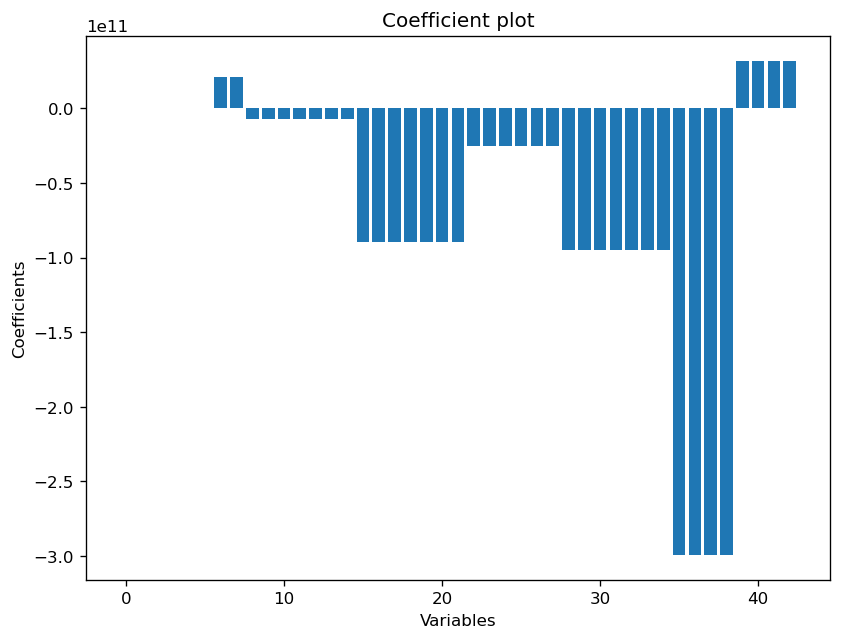

In [38]:
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='b')
a = range(len(train_x.columns))
b = lr.coef_
plt.bar( a, b )
plt.xlabel( "Variables")
plt.ylabel('Coefficients')
plt.title('Coefficient plot')

Here we can see that the model depends upon some Independent variables toos much, But these coefficients are not suitable for interpretation because these are not scaled, therefore we will perform the interpretation in this note book later.

## Cleaning data

### Outlier Removal

In [39]:
data= dataCopy.copy()
data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'distance', 'speed', 'pickup_day', 'dropoff_day',
       'pickup_day_no', 'dropoff_day_no', 'pickup_month', 'dropoff_month',
       'pickup_hour', 'dropoff_hour', 'pickup_timezone', 'dropoff_timezone'],
      dtype='object')

In [40]:
data= data.drop(["pickup_datetime","dropoff_datetime","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","pickup_day_no","dropoff_day_no"], axis=1)

In [41]:
# Numerical datatypes
data.select_dtypes(include=['int64','float64','Int64']).dtypes

vendor_id            int64
passenger_count      int64
trip_duration        int64
distance           float64
speed              float64
pickup_hour          int64
dropoff_hour         int64
dtype: object

### Target variable  exploration

<AxesSubplot:xlabel='trip_duration'>

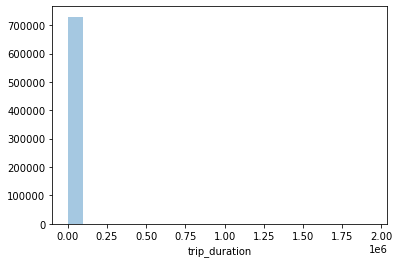

In [42]:
sns.distplot(data['trip_duration'],kde=False,bins=20)

<AxesSubplot:xlabel='trip_duration'>

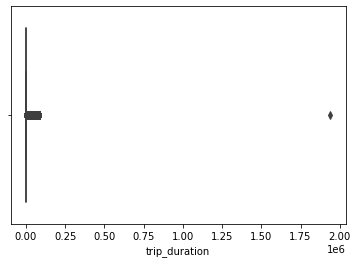

In [43]:
sns.boxplot(x=(data["trip_duration"]))

Need to Remove Outliers to visulaise these plots

In [44]:
# removing outliers of Num columns based on Z score

from scipy import stats
data= data[(np.abs(stats.zscore(data["trip_duration"])) < 3)]
data= data[(np.abs(stats.zscore(data["distance"])) < 3)]
data= data[(np.abs(stats.zscore(data["passenger_count"])) < 3)]
data= data[(np.abs(stats.zscore(data["speed"])) < 3)]


In [45]:
data.head()

,id,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,distance,speed,pickup_day,dropoff_day,pickup_month,dropoff_month,pickup_hour,dropoff_hour,pickup_timezone,dropoff_timezone
0,id1080784,2,1,N,400,1.20,10.800000,Monday,Monday,February,February,16,16,Evening,Evening
1,id0889885,1,2,N,1100,4.13,13.516364,Friday,Friday,March,March,23,23,Night,Night
2,id0857912,2,2,N,1635,7.25,15.963303,Sunday,Sunday,February,February,17,18,Evening,Evening
4,id0232939,1,1,N,848,4.33,18.382075,Wednesday,Wednesday,February,February,6,6,Morning,Morning
5,id1918069,2,2,N,1455,3.12,7.719588,Sunday,Sunday,February,February,18,18,Evening,Evening


## One-hot Encoding

In [46]:
catcol

['store_and_fwd_flag',
 'pickup_day',
 'dropoff_day',
 'pickup_month',
 'dropoff_month',
 'pickup_timezone',
 'dropoff_timezone']

In [47]:
data= pd.get_dummies(data, columns = catcol)


In [48]:
data= data.drop(["id","pickup_hour","dropoff_hour"], axis=1)
data.head()

,vendor_id,passenger_count,trip_duration,distance,speed,store_and_fwd_flag_N,store_and_fwd_flag_Y,pickup_day_Friday,pickup_day_Monday,pickup_day_Saturday,...,dropoff_month_March,dropoff_month_May,pickup_timezone_Evening,pickup_timezone_Morning,pickup_timezone_Night,pickup_timezone_Noon,dropoff_timezone_Evening,dropoff_timezone_Morning,dropoff_timezone_Night,dropoff_timezone_Noon
0,2,1,400,1.20,10.800000,1,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
1,1,2,1100,4.13,13.516364,1,0,1,0,0,...,1,0,0,0,1,0,0,0,1,0
2,2,2,1635,7.25,15.963303,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,1,1,848,4.33,18.382075,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,2,2,1455,3.12,7.719588,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


# 1. Regression Benchmark Model
## Shuffling and Creating Train and Test Set

In [49]:
from sklearn.utils import shuffle

# Shuffling the Dataset
data = shuffle(data, random_state = 42)
#creating 4 divisions
div = int(data.shape[0]/4)

# 3 parts to train set and 1 part to test set
train = data.iloc[:3*div+1,:]
test = data.iloc[3*div+1:]

## Simple Mean ( mean of trip_duration)

In [50]:
# storing simple mean in a new column in the test set as "simple_mean"
test['simple_mean'] = train['trip_duration'].mean()

In [51]:
#calculating mean absolute error
from sklearn.metrics import mean_absolute_error as MAE

simple_mean_error = MAE(test['trip_duration'] , test['simple_mean'])
print ("BaseLine error: ", simple_mean_error)

BaseLine error:  413.6030627404351


* BaseLine error after outlier treatment:  413.6030627404351


# 2. Linear Regression with all features

### Segregating variables: Independent and Dependent Variables

In [52]:
#seperating independent and dependent variables
x = data.drop(['trip_duration'], axis=1)
y = data['trip_duration']
x.shape, y.shape

((679059, 41), (679059,))

## Splitting the data into train set and the test set

In [53]:
# Importing the train test split function
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(x,y, random_state = 42)

## Implementing Linear Regression

In [54]:
#importing Linear Regression and metric mean square error
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_absolute_error as mae

In [55]:
# Creating instance of Linear Regresssion
lr = LR(normalize = True)

# Fitting the model
lr.fit(train_x, train_y)

LinearRegression(normalize=True)

In [56]:
# Predicting over the Train Set and calculating error
train_predict = lr.predict(train_x)
k = mae(train_predict, train_y)
print('Training Mean Absolute Error', k )

Training Mean Absolute Error 153.6681553287492


In [57]:
# Predicting over the Test Set and calculating error
test_predict = lr.predict(test_x)
k = mae(test_predict, test_y)
print('Test Mean Absolute Error    ', k )

Test Mean Absolute Error     154.01882602420994


* Training Mean Absolute Error after outlier treatment: 153.6681553287492
* Test Mean Absolute Error after outlier treatment: 154.01882602420994


### Parameters of Linear Regression

In [58]:
lr.coef_

array([ 1.25076960e+00,  1.59281634e+00,  2.16092764e+02, -4.72694961e+01,
       -2.43332703e+15, -2.43332703e+15, -5.81924297e+13, -5.81924297e+13,
       -5.81924297e+13, -5.81924297e+13, -5.81924297e+13, -5.81924297e+13,
       -5.81924297e+13,  5.64211015e+14,  5.64211015e+14,  5.64211015e+14,
        5.64211015e+14,  5.64211015e+14,  5.64211015e+14,  5.64211015e+14,
       -5.12971598e+13, -5.12971598e+13, -5.12971598e+13, -5.12971598e+13,
       -5.12971598e+13, -5.12971598e+13,  2.13100921e+14,  2.13100921e+14,
        2.13100921e+14,  2.13100921e+14,  2.13100921e+14,  2.13100921e+14,
        2.13100921e+14, -1.39513062e+14, -1.39513062e+14, -1.39513062e+14,
       -1.39513062e+14, -5.26422319e+14, -5.26422319e+14, -5.26422319e+14,
       -5.26422319e+14])

### Plotting the coefficients

Text(0.5, 1.0, 'Coefficient plot')

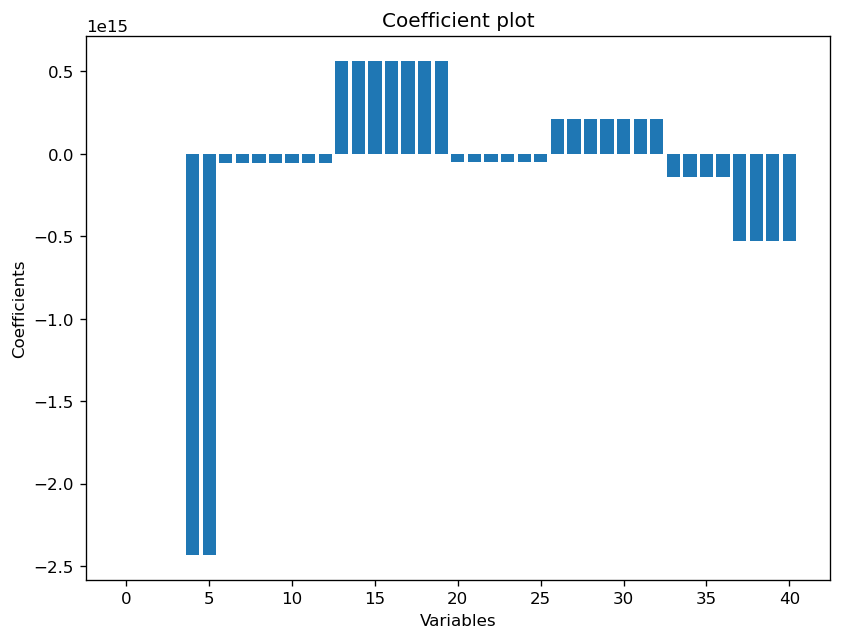

In [59]:
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='b')
a = range(len(train_x.columns))
b = lr.coef_
plt.bar( a, b )
plt.xlabel( "Variables")
plt.ylabel('Coefficients')
plt.title('Coefficient plot')

## Checking assumptions of Linear Model

In [60]:
# Arranging and calculating the Residuals
residuals = pd.DataFrame({
    'fitted values' : test_y,
    'predicted values' : test_predict,
})

residuals['residuals'] = residuals['fitted values'] - residuals['predicted values']
residuals.head()

,fitted values,predicted values,residuals
415721,411,512.0,-101.0
487958,1805,1308.5,496.5
229642,806,773.0,33.0
176492,806,777.0,29.0
589701,1149,1020.0,129.0


### Plotting residual curve (Is there constant Variance OR Homoscedastic?)

ValueError: x and y must be the same size

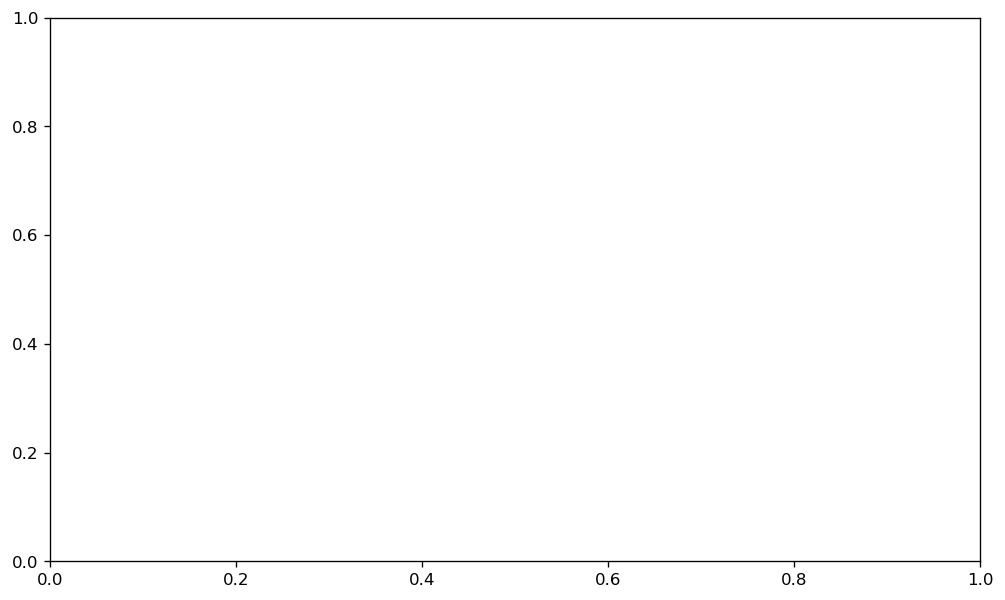

In [61]:
plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,2131)
k = [0 for i in range(0,2131)]
plt.scatter( f, residuals.residuals[:], label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.ylim(-4000, 4000)
plt.legend()

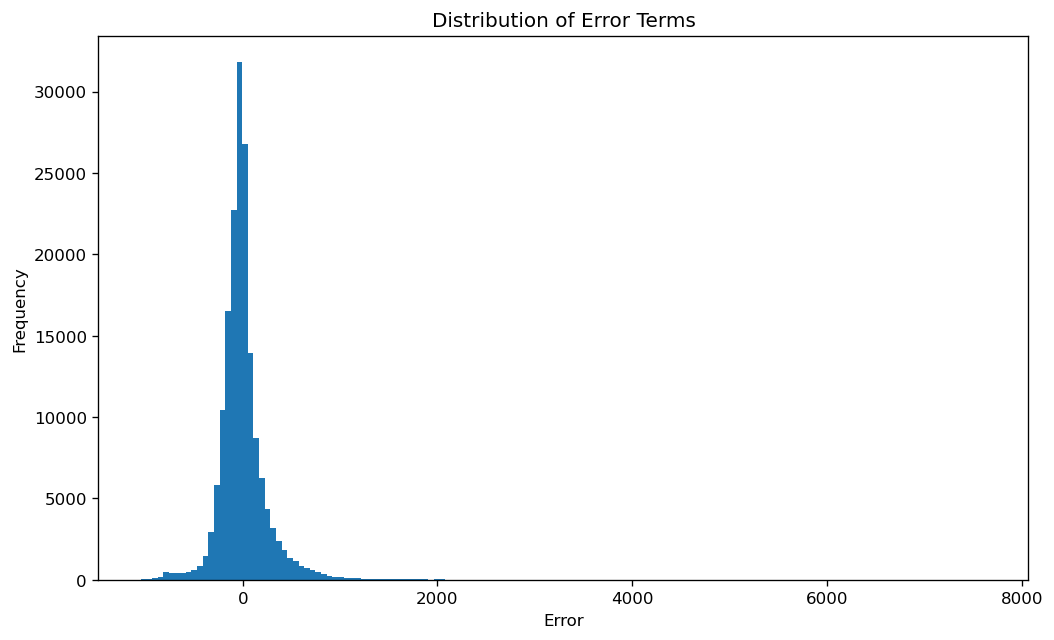

In [62]:
# Histogram for distribution
plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
plt.hist(residuals.residuals, bins = 150)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Distribution of Error Terms')
plt.show()

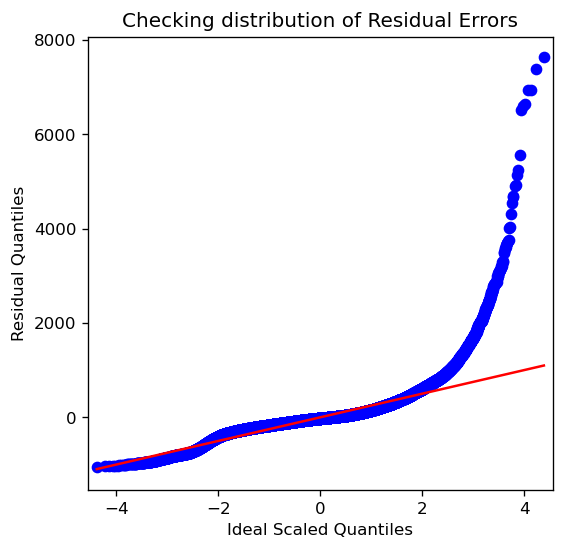

In [63]:
# importing the QQ-plot from the from the statsmodels
from statsmodels.graphics.gofplots import qqplot

## Plotting the QQ plot
fig, ax = plt.subplots(figsize=(5,5) , dpi = 120)
qqplot(residuals.residuals, line = 's' , ax = ax)
plt.ylabel('Residual Quantiles')
plt.xlabel('Ideal Scaled Quantiles')
plt.title('Checking distribution of Residual Errors')
plt.show()

## Model evaluation


## Preprocessing 

In [64]:
data.columns

Index(['vendor_id', 'passenger_count', 'trip_duration', 'distance', 'speed',
       'store_and_fwd_flag_N', 'store_and_fwd_flag_Y', 'pickup_day_Friday',
       'pickup_day_Monday', 'pickup_day_Saturday', 'pickup_day_Sunday',
       'pickup_day_Thursday', 'pickup_day_Tuesday', 'pickup_day_Wednesday',
       'dropoff_day_Friday', 'dropoff_day_Monday', 'dropoff_day_Saturday',
       'dropoff_day_Sunday', 'dropoff_day_Thursday', 'dropoff_day_Tuesday',
       'dropoff_day_Wednesday', 'pickup_month_April', 'pickup_month_February',
       'pickup_month_January', 'pickup_month_June', 'pickup_month_March',
       'pickup_month_May', 'dropoff_month_April', 'dropoff_month_February',
       'dropoff_month_January', 'dropoff_month_July', 'dropoff_month_June',
       'dropoff_month_March', 'dropoff_month_May', 'pickup_timezone_Evening',
       'pickup_timezone_Morning', 'pickup_timezone_Night',
       'pickup_timezone_Noon', 'dropoff_timezone_Evening',
       'dropoff_timezone_Morning', 'dropoff_tim

### Feature Scaling

In [65]:
from sklearn.preprocessing import MinMaxScaler
num_cols = ["trip_duration","distance","speed"]
for i in num_cols:
    data[i] = np.log(data[i] + 17000)

std = MinMaxScaler()
scaled = std.fit_transform(data[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

In [66]:
data2 = data.copy()
data = data.drop(columns = num_cols,axis = 1)
data = data.merge(scaled,left_index=True,right_index=True,how = "left")

In [67]:
data.head()

,vendor_id,passenger_count,store_and_fwd_flag_N,store_and_fwd_flag_Y,pickup_day_Friday,pickup_day_Monday,pickup_day_Saturday,pickup_day_Sunday,pickup_day_Thursday,pickup_day_Tuesday,...,pickup_timezone_Morning,pickup_timezone_Night,pickup_timezone_Noon,dropoff_timezone_Evening,dropoff_timezone_Morning,dropoff_timezone_Night,dropoff_timezone_Noon,trip_duration,distance,speed
424017,2,1,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0.083956,0.142136,0.274612
461073,1,1,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0.033163,0.050418,0.249589
612497,1,1,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0.048268,0.093544,0.317148
403813,2,1,1,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0.018888,0.079574,0.692351
152876,1,1,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0.138648,0.786966,0.906934


## Linear Regression with all features

### Shuffling and Creating Train and Test Set

In [68]:
from sklearn.utils import shuffle

# Shuffling the Dataset
data = shuffle(data, random_state = 42)

## Segregating variables: Independent and Dependent Variables 

In [69]:
#seperating independent and dependent variables
x = data.drop(['trip_duration'], axis=1)
y = data['trip_duration']
x.shape, y.shape

((679059, 41), (679059,))

In [70]:
x.isna().sum()

vendor_id                       0
passenger_count                 0
store_and_fwd_flag_N            0
store_and_fwd_flag_Y            0
pickup_day_Friday               0
pickup_day_Monday               0
pickup_day_Saturday             0
pickup_day_Sunday               0
pickup_day_Thursday             0
pickup_day_Tuesday              0
pickup_day_Wednesday            0
dropoff_day_Friday              0
dropoff_day_Monday              0
dropoff_day_Saturday            0
dropoff_day_Sunday              0
dropoff_day_Thursday            0
dropoff_day_Tuesday             0
dropoff_day_Wednesday           0
pickup_month_April              0
pickup_month_February           0
pickup_month_January            0
pickup_month_June               0
pickup_month_March              0
pickup_month_May                0
dropoff_month_April             0
dropoff_month_February          0
dropoff_month_January           0
dropoff_month_July              0
dropoff_month_June              0
dropoff_month_

In [71]:
x=x.fillna(x.mean())

In [72]:
y.isna().sum()

46855

In [73]:
y=y.fillna(y.mean())

In [74]:
y.isna().sum()

0

# Splitting the data into train set and the test set

In [75]:
# Importing the train test split function
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(x,y, random_state = 42)

In [76]:
train_x.isna().sum()

vendor_id                   0
passenger_count             0
store_and_fwd_flag_N        0
store_and_fwd_flag_Y        0
pickup_day_Friday           0
pickup_day_Monday           0
pickup_day_Saturday         0
pickup_day_Sunday           0
pickup_day_Thursday         0
pickup_day_Tuesday          0
pickup_day_Wednesday        0
dropoff_day_Friday          0
dropoff_day_Monday          0
dropoff_day_Saturday        0
dropoff_day_Sunday          0
dropoff_day_Thursday        0
dropoff_day_Tuesday         0
dropoff_day_Wednesday       0
pickup_month_April          0
pickup_month_February       0
pickup_month_January        0
pickup_month_June           0
pickup_month_March          0
pickup_month_May            0
dropoff_month_April         0
dropoff_month_February      0
dropoff_month_January       0
dropoff_month_July          0
dropoff_month_June          0
dropoff_month_March         0
dropoff_month_May           0
pickup_timezone_Evening     0
pickup_timezone_Morning     0
pickup_tim

In [77]:
train_y.isna().sum()

0

### Implementing Linear Regression

In [78]:
#importing Linear Regression and metric mean square error
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_absolute_error as mae

#### Training Model

In [79]:
# Creating instance of Linear Regresssion with Normalised Data
lr = LR(normalize = True)

# Fitting the model
lr.fit(train_x, train_y)

LinearRegression(normalize=True)

#### Predicting over the train set

In [80]:
# Predicting over the Train Set and calculating error
train_predict = lr.predict(train_x)
k = mae(train_predict, train_y)
print('Training Mean Absolute Error', k )

Training Mean Absolute Error 0.014390202205253897


#### Predicting over the test set

In [82]:
# Predicting over the Test Set and calculating error
test_predict = lr.predict(test_x)
k = mae(test_predict, test_y)
print('Test Mean Absolute Error    ', k )

Test Mean Absolute Error     0.014374795788467263
